# Counting Machine Washer Parts in an Image using an Image Processing Pipeline

In [1]:
import os
from os import path
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv
from skimage.filters import gaussian, threshold_multiotsu
from scipy import signal
from skimage import data
from skimage.filters import threshold_multiotsu
import random
import json
from google.colab.patches import cv2_imshow

if 'google.colab' in str(get_ipython()):
  from google.colab import files
  from google.colab.patches import cv2_imshow
  
  from google.colab import drive 
  drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

Run the following cell if images are to be uploaded

In [2]:
#uploaded = files.upload()

Run the following cell if the dataset needs to be unzipped

In [3]:
#if path.exists('/content/drive/Shareddrives/CIS680 - Final Project Fall\'21/dataset') == False:
   #os.mkdir('/content/drive/Shareddrives/CIS680 - Final Project Fall \'21/dataset')
#!unzip -u "/content/drive/Shareddrives/CIS680 - Final Project Fall '21/dataset.zip" -d "/content/drive/Shareddrives/CIS680 - Final Project Fall '21/dataset"

Run the following cell to load an individual image

In [4]:
#src = cv2.imread("/content/0_angle0_img.png", cv2.IMREAD_COLOR)

## 1. Convert image to HSV

To isolate the Saturation channel

In [5]:
def image_to_HSV(src, show = False , select_source = 2):
    '''
    Input:
      src:            Source Image
      show:           If set to True, displays converted image
      select_source:  1 for Hue channel, 2 for Saturation channel, 3 for Value channel

    Returns:
      source:         Selected channel of Image
    '''
    src_hsv = cv2.cvtColor(src, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(src_hsv)

    # Plot different Channels of HSV
    if show == True:
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(8, 2), dpi=190)
        ax0.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
        ax0.set_title("RGB image")
        ax0.axis('off')
        ax1.imshow(h, cmap='hsv')
        ax1.set_title("Hue channel")
        ax1.axis('off')
        ax2.imshow(s)
        ax2.set_title("Saturation channel")
        ax2.axis('off')
        ax3.imshow(v)
        ax3.set_title("Value channel")
        ax3.axis('off')
        fig.tight_layout()
    if select_source==1:
        source = h
    elif select_source==2:
        source = s
    elif select_source==3:
        source = v      
    # cv2_imshow(s)
    return source

## 2. Gaussian Filter

To remove noise from the image

In [6]:
def Gaussian(source, show = False):
    '''
    Input:
      source:         Source image
      show:           If True, display Gaussian filtered image
    
    Returns:
      filtered_image: Gaussian filtered image
    '''
    filtered_image = cv2.GaussianBlur(source, (3,3),0,0)
    if show == True:
        fig, ax = plt.subplots(dpi=190)
        ax.imshow(filtered_image)
        ax.set_title("Gaussian Filtered Image")
        ax.axis('off')
        fig.tight_layout()
    # cv2_imshow(filtered_image)
    return filtered_image

## 3. a) Otsu Thresholding

Perform 2-level Otsu thresholding

In [7]:
def Otsu(source, show = False,c = 0):
    '''
    Input:
      source:             Source image
      show:               If True, display Otsu thresholded image
      c = otsu constant
    
    Returns:
      thresholded_image:  Otsu thresholded image
    '''
    image = source
    ret2, thresholded_image = cv2.threshold(source, 0,250, cv2.THRESH_BINARY+cv2.THRESH_OTSU + c)
    
    if show == True:
        fig, ax = plt.subplots(dpi=190)
        ax.imshow(thresholded_image)
        ax.set_title("Otsu Thresholded Image")
        ax.axis('off')
        fig.tight_layout()    
    #cv2_imshow(thresholded_image)
    return thresholded_image  

##3. b) Tri-level Otsu Thresholding 


In [8]:
def MultiOtsu(source, show = False,levels = 3):
    image = source
    # Setting the font size for all plots.
    matplotlib.rcParams['font.size'] = 9
    val = random.randrange(500)
    # Applying multi-Otsu threshold for the default value, generating
    # three classes.
    thresholds = threshold_multiotsu(image,classes=levels)

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(image, bins=thresholds)
    if show == True:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))
        # Plotting the original image.
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('Original')
        ax[0].axis('off')

        # Plotting the histogram and the two thresholds obtained from
        # multi-Otsu.
        ax[1].hist(image.ravel(), bins=255)
        ax[1].set_title('Histogram')
        for thresh in thresholds:
            ax[1].axvline(thresh, color='r')
            
        # Plotting the Multi Otsu result.
        ax[2].imshow(regions, cmap='jet')
        ax[2].set_title('Multi-Otsu result')
        ax[2].axis('off')

        plt.subplots_adjust()

        plt.show()
    #print(regions.shape[0])    
    img = np.zeros((levels,regions.shape[0],regions.shape[1]))    
    for i in range(levels):
      #print(regions.shape)
      #print(img[i].shape)  
      img[i][regions == i] = 100 
    return img    


## 4. Sobel Edge Detection

Generate an edge map for the input image

In [9]:
def Sobel(source, show = False):
    '''
    Input:
      source:             Source image
      show:               If True, display Sobel filtered image
    
    Returns:
      sobel_out:  Edge map of source image
    ''' 
    sobel_8u = cv2.Sobel(source, cv2.CV_64F, 0, 1, ksize=1)
    sobel_out = np.uint8(np.absolute(sobel_8u))
    if show == True:
        fig, ax = plt.subplots(dpi=190)
        ax.imshow(sobel_out)
        ax.set_title("Sobel Edge Detection")
        ax.axis('off')
        fig.tight_layout()
    # cv2_imshow(sobel_out)
    return sobel_out

## 5. Hough Transform

Applies a Hough Circle Transform to the generated edge map of the source image

NOTE: HoughCircles only takes in CV_8U format images

Inputting MaxRadius Values of <0 returns the centers without finding the respective radii

In [10]:
def Circles(source, param1 = 100, param2 = 6, minRadius = 15, maxRadius = 25, show = False):
    '''
    Input:
      source:         Source image
      param1, param2: Parameters for Hough Circles
      minRadius:      Minimum radius of generated circles
      maxRadius:      Maximum radius of generated circles
      show:           If True, display image with generated circles
    
    Returns:
      Number of detected circles
    '''
    #To detect outer circles: minRadius=15, maxRadius = 25, param2 = 6
    #To detect inner circles: minRadius=5, maxRadius = 15, param2 = 6
    #for final testing: param1 = 300, param2 =1 

    circles = cv2.HoughCircles(source, 
                              cv2.HOUGH_GRADIENT,
                              dp =1,
                              minDist = 20,
                              param1 = param1 ,
                              param2 = param2,
                              minRadius =minRadius,
                              maxRadius = maxRadius)
    
    circles = np.uint16(np.around(circles[0]))
    print("circles detected =", circles.shape[0])
    if show == True:
        output = img.copy()
        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
          # draw the circle in the output image, then draw a rectangle
          # corresponding to the center of the circle
          cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        # show the output image
        #cv2_imshow(source)
        cv2_imshow(np.hstack([img, output]))
        cv2.waitKey(0)
    return len(circles)    

# Full Pipeline

## Obtaining Ground Truth Annotations 


Parsing the JSON file to get object count for each image

In [11]:
#Function to get number of objects in the image

def get_label(_id):
    annos = [s for s in imgs_anns["annotations"] if s["image_id"] == _id]
    return len(annos)

json_file = os.path.join("/content/drive/Shareddrives/CIS680 - Final Project Fall '21/dataset", "annotations.json")
with open(json_file) as f:
  imgs_anns = json.load(f)
file2id ={}
for image in imgs_anns["images"]:
  file2id[image["file_name"]] = image["id"]  
#print(get_label(file2id["img/899_angle8_img.png"]))


## Main function to run the whole pipeline

In [12]:
def get_thres_images(img, show = False,levels = 4):
    '''
    Inputs:
      img:    Source Image
      show:   If True, display processed images during intermediary steps

    Returns:
      img1,img2,img3: three thresholded images
    '''
    img = image_to_HSV(img, show)
    img = Gaussian(img, show)
    img = MultiOtsu(img,True,levels)
    
    #cv2.imwrite("/content/drive/Shareddrives/CIS680 - Final Project Fall '21/OtsuTesting/402_angle5_img_%d.png"%(threshold), img)
  
    #return img

In [16]:
def get_count(img, show = False,threshold = 10):
    '''
    Inputs:
      img:    Source Image
      show:   If True, display processed images during intermediary steps

    Returns:
      count:  Count of circles detected in image
    '''
    img = image_to_HSV(img,show=show)
    img = Gaussian(img, show=show)
    img = Otsu(img, show=show)
    img = Sobel(img, show=show)
    #cv2.imwrite("/content/drive/Shareddrives/CIS680 - Final Project Fall '21/OtsuTesting/402_angle5_img_%d.png"%(threshold), img)
    count = Circles(img, show=show)
    return count

In [17]:
"""
directory = '/content/drive/Shareddrives/CIS680 - Final Project Fall \'21/dataset-split/val'
i = 0
show =False
for filename in os.listdir(directory):
    if i<1000:
      if filename.endswith(".png"):
        img = cv2.imread(directory+'/'+filename,cv2.IMREAD_COLOR)
        img = get_thres_images(img,levels = 2)
        for j in range(img.shape[0]):
            if show == True:
                fig, ax = plt.subplots(dpi=190)
                ax.imshow(img[j])
                ax.axis('off')
                fig.tight_layout()   
            cv2.imwrite("/content/drive/Shareddrives/CIS680 - Final Project Fall \'21/dataset-split/valOtsu/%s"%(filename.replace(".png","%s.png"%(j))), img[j])
        i+=1
"""

'\ndirectory = \'/content/drive/Shareddrives/CIS680 - Final Project Fall \'21/dataset-split/val\'\ni = 0\nshow =False\nfor filename in os.listdir(directory):\n    if i<1000:\n      if filename.endswith(".png"):\n        img = cv2.imread(directory+\'/\'+filename,cv2.IMREAD_COLOR)\n        img = get_thres_images(img,levels = 2)\n        for j in range(img.shape[0]):\n            if show == True:\n                fig, ax = plt.subplots(dpi=190)\n                ax.imshow(img[j])\n                ax.axis(\'off\')\n                fig.tight_layout()   \n            cv2.imwrite("/content/drive/Shareddrives/CIS680 - Final Project Fall \'21/dataset-split/valOtsu/%s"%(filename.replace(".png","%s.png"%(j))), img[j])\n        i+=1\n'

circles detected = 58


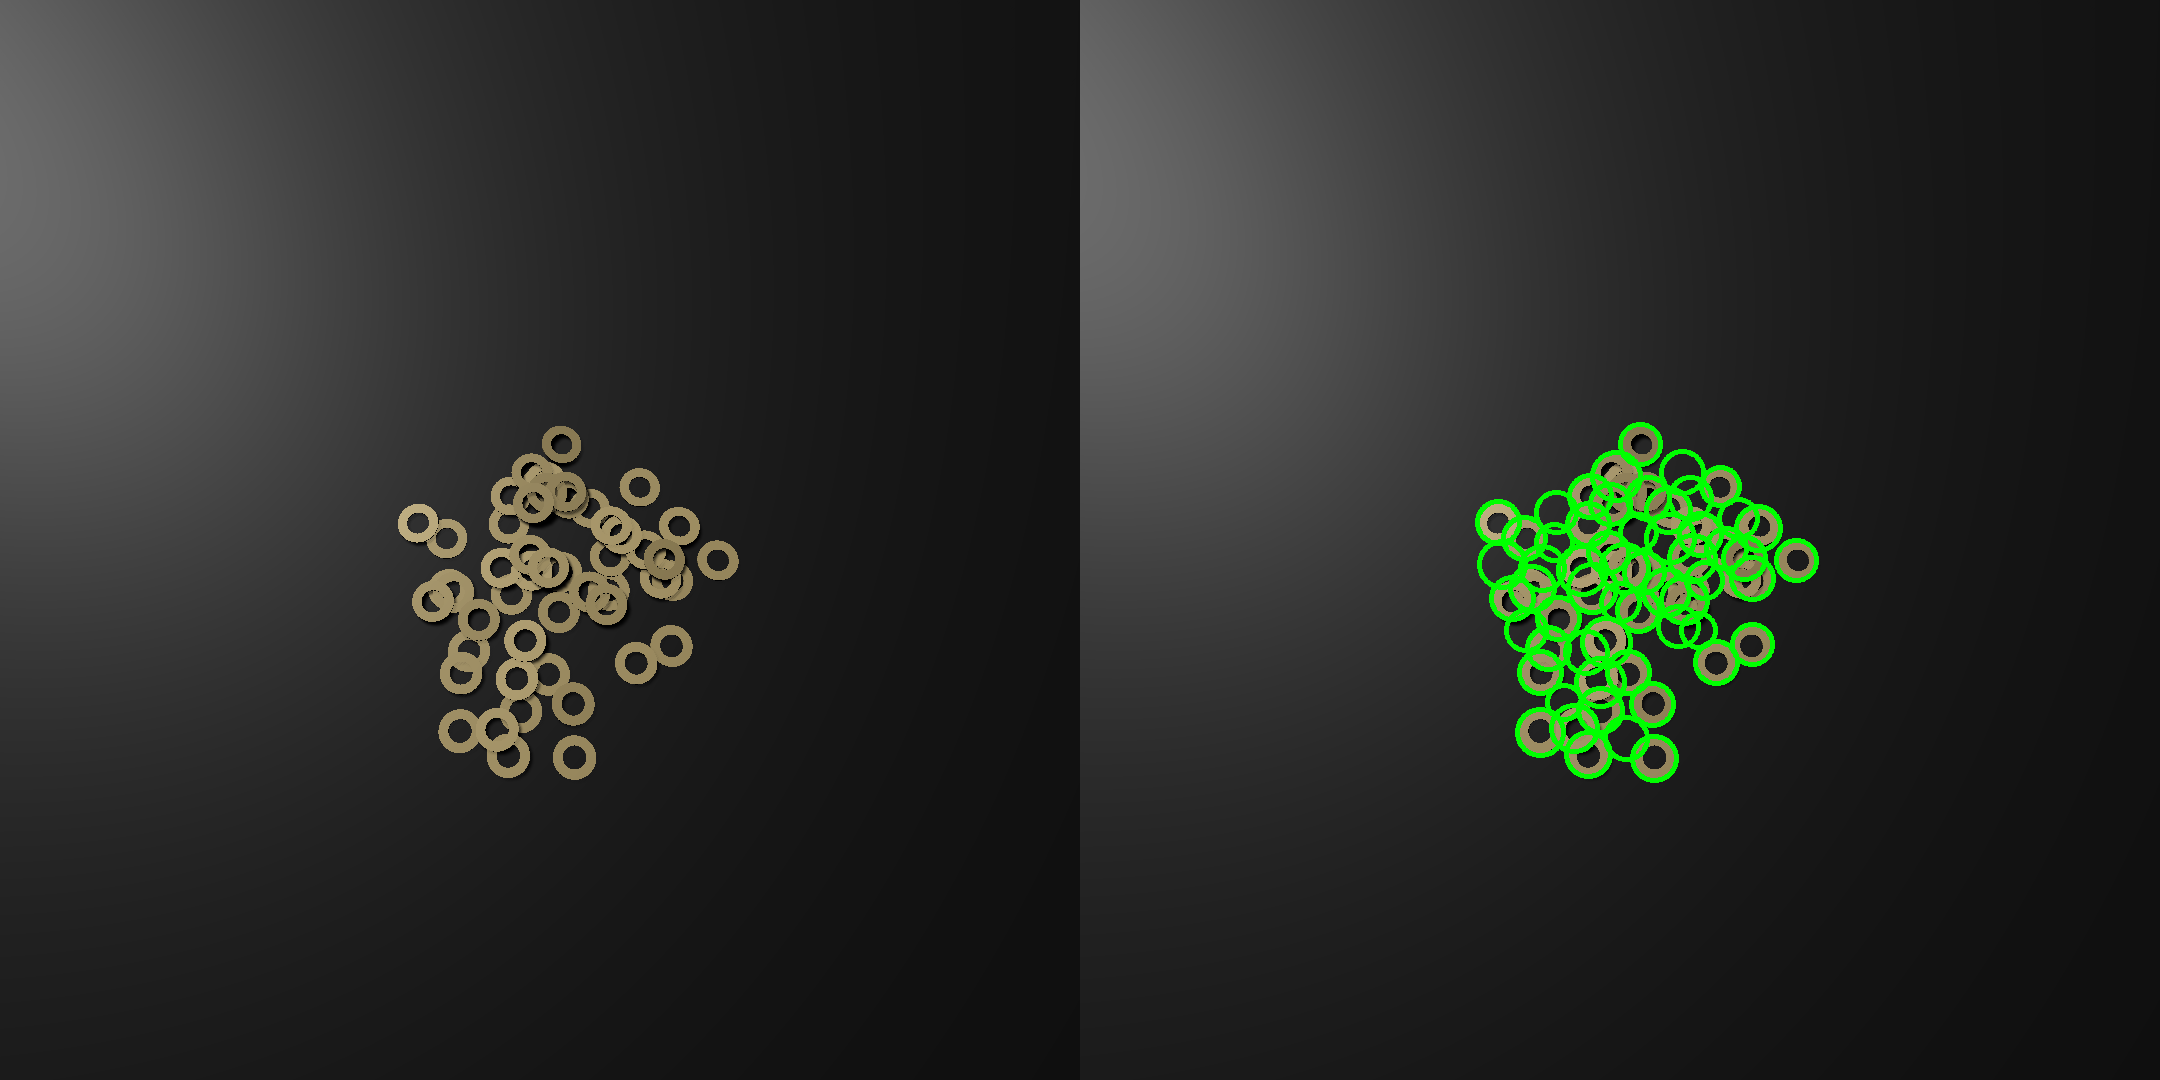

58


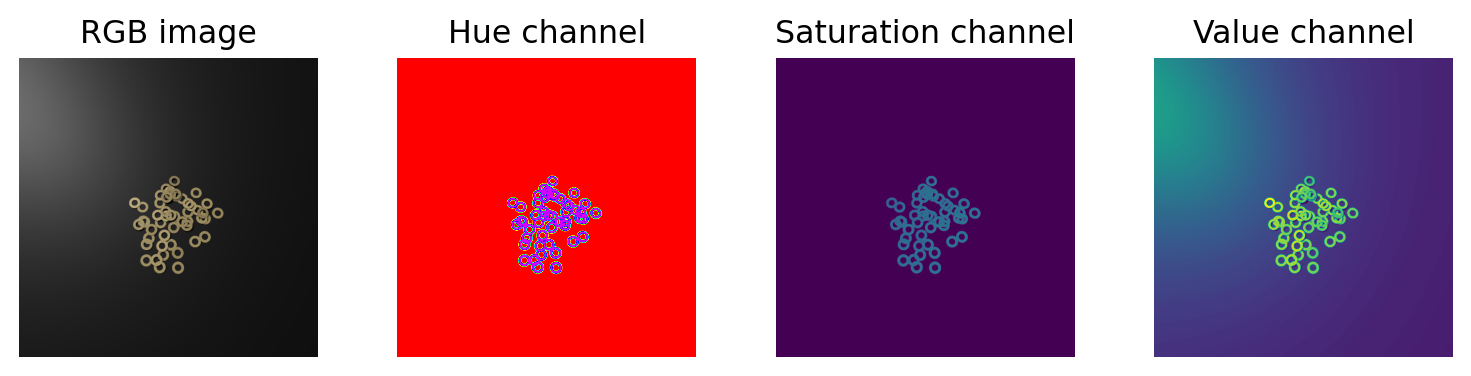

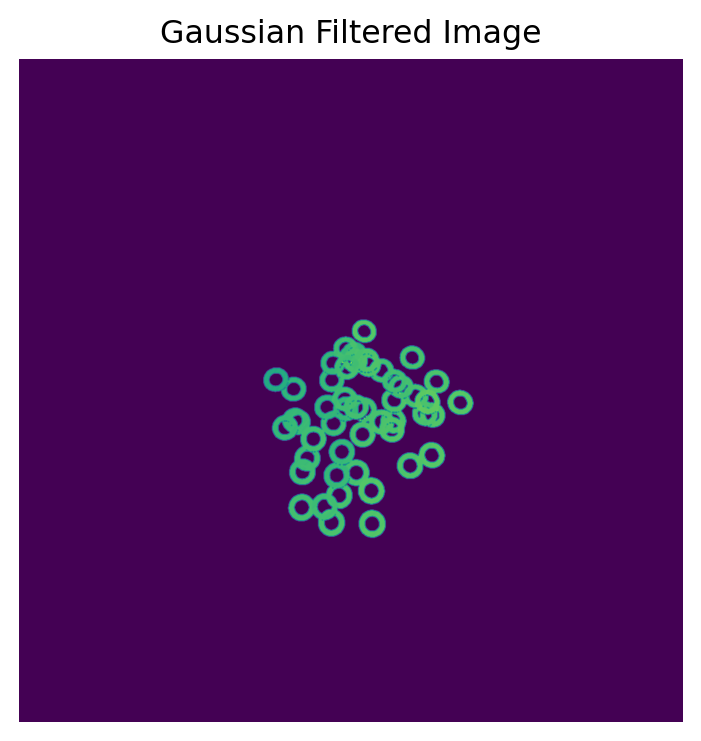

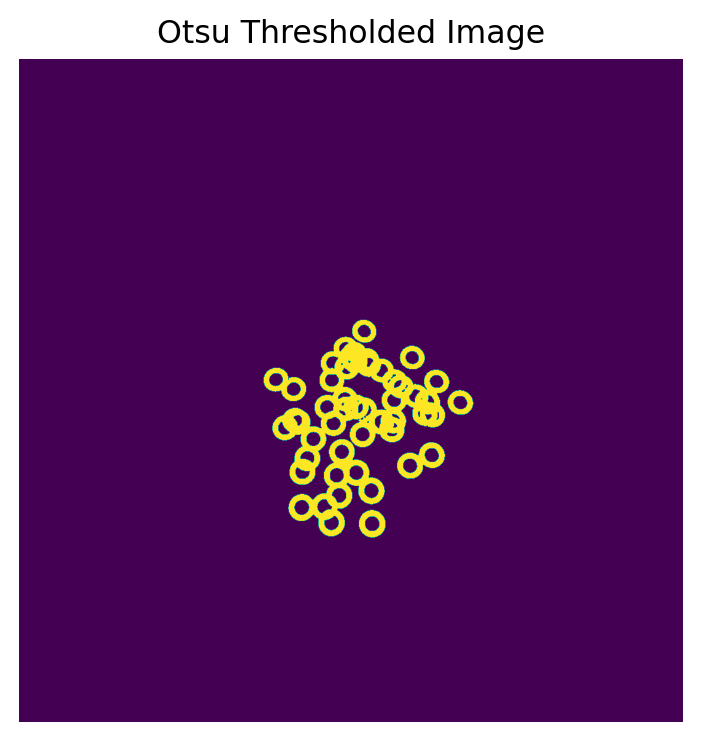

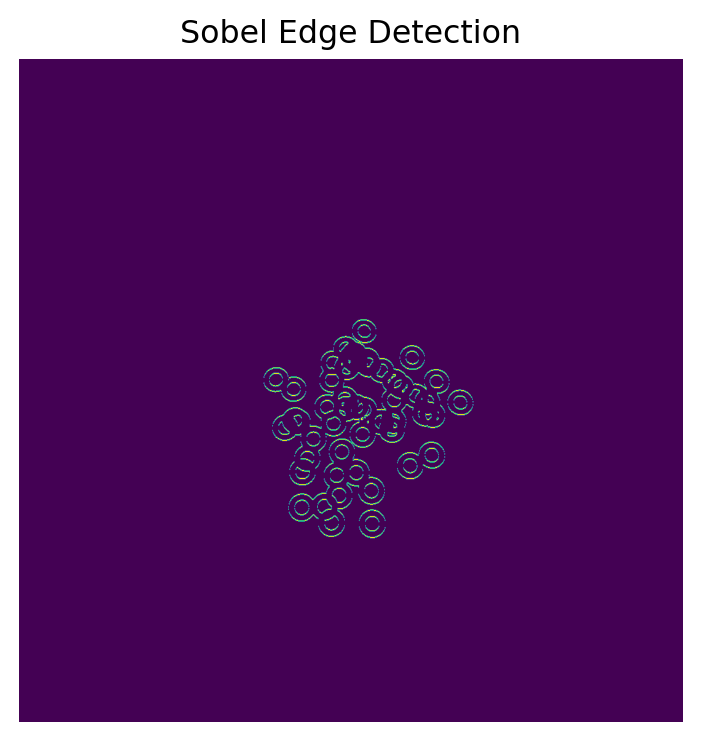

In [18]:

img = cv2.imread("/content/drive/Shareddrives/CIS680 - Final Project Fall \'21/dataset/134_angle4_img.png")
print(get_count(img,show = True))


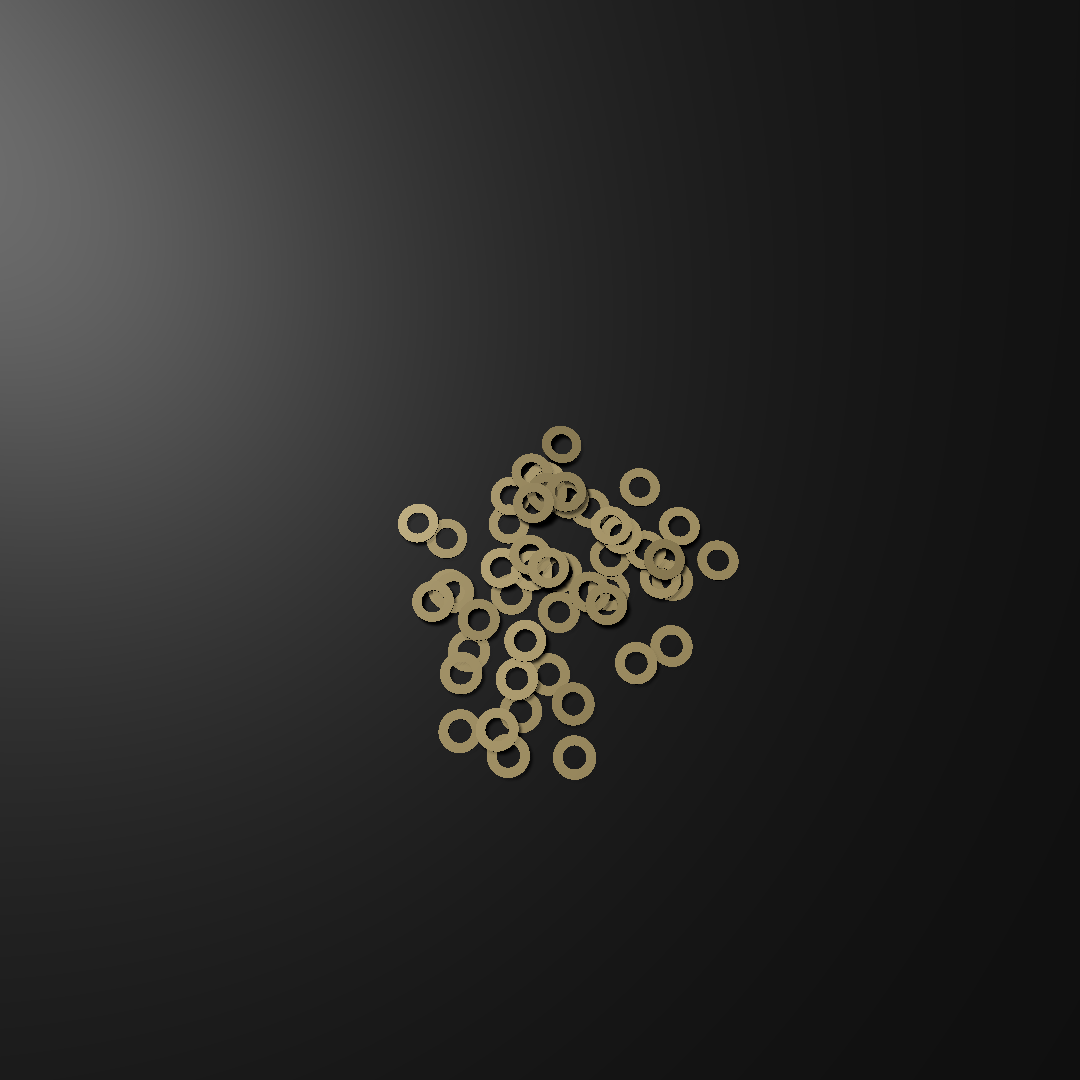

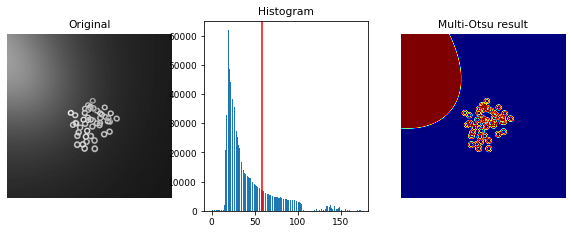

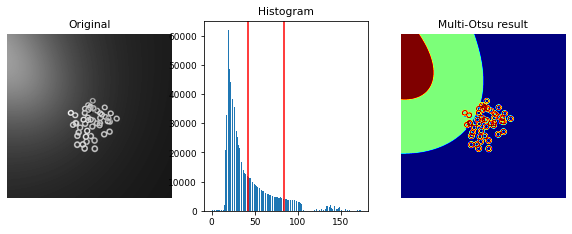

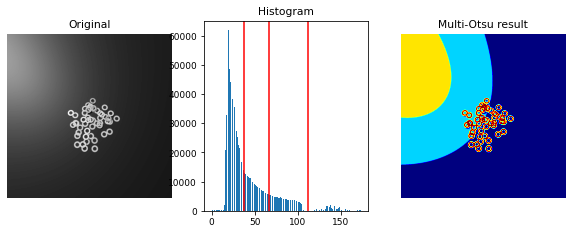

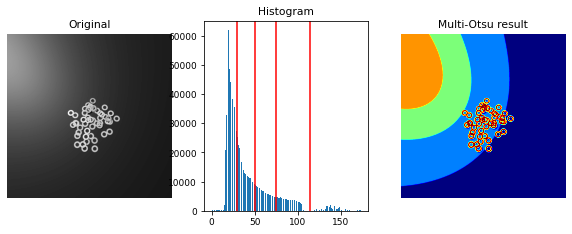

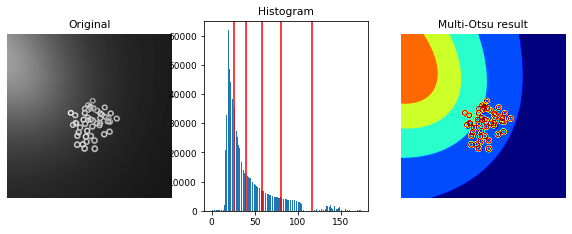

In [ ]:
"""
filepath = "/content/drive/Shareddrives/CIS680 - Final Project Fall \'21/dataset/134_angle4_img.png"
img = cv2.imread(filepath,cv2.IMREAD_COLOR)
cv2_imshow(img)
for i in range(2,7):
    output = MultiOtsu(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),levels = i,show = True)   
"""        


## Evaluation Metrics

Algorithm results evaluated on Root Mean Squared Error (RMSE) & Mean Absolute Error (MAE)

image name:121_angle1_img.png


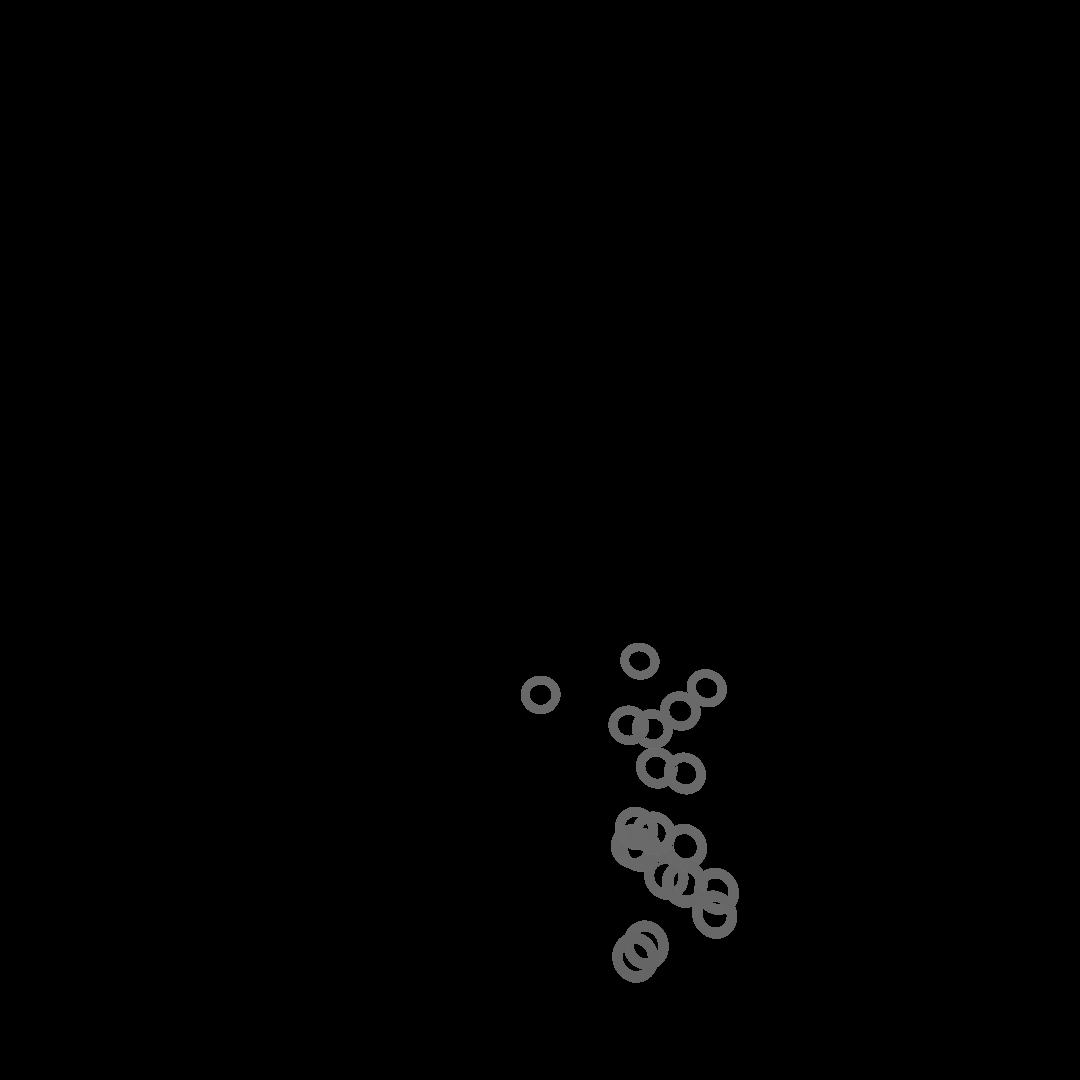

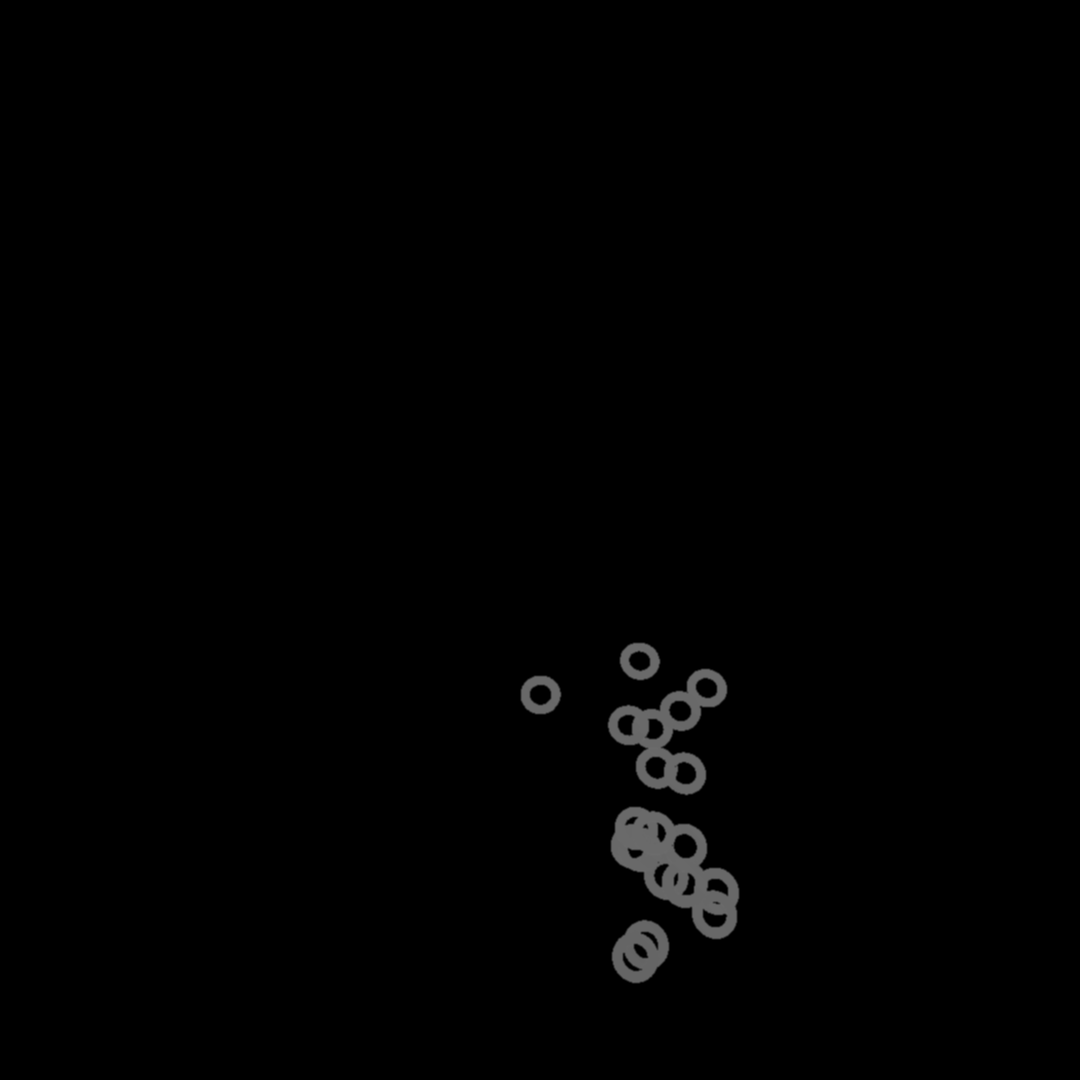

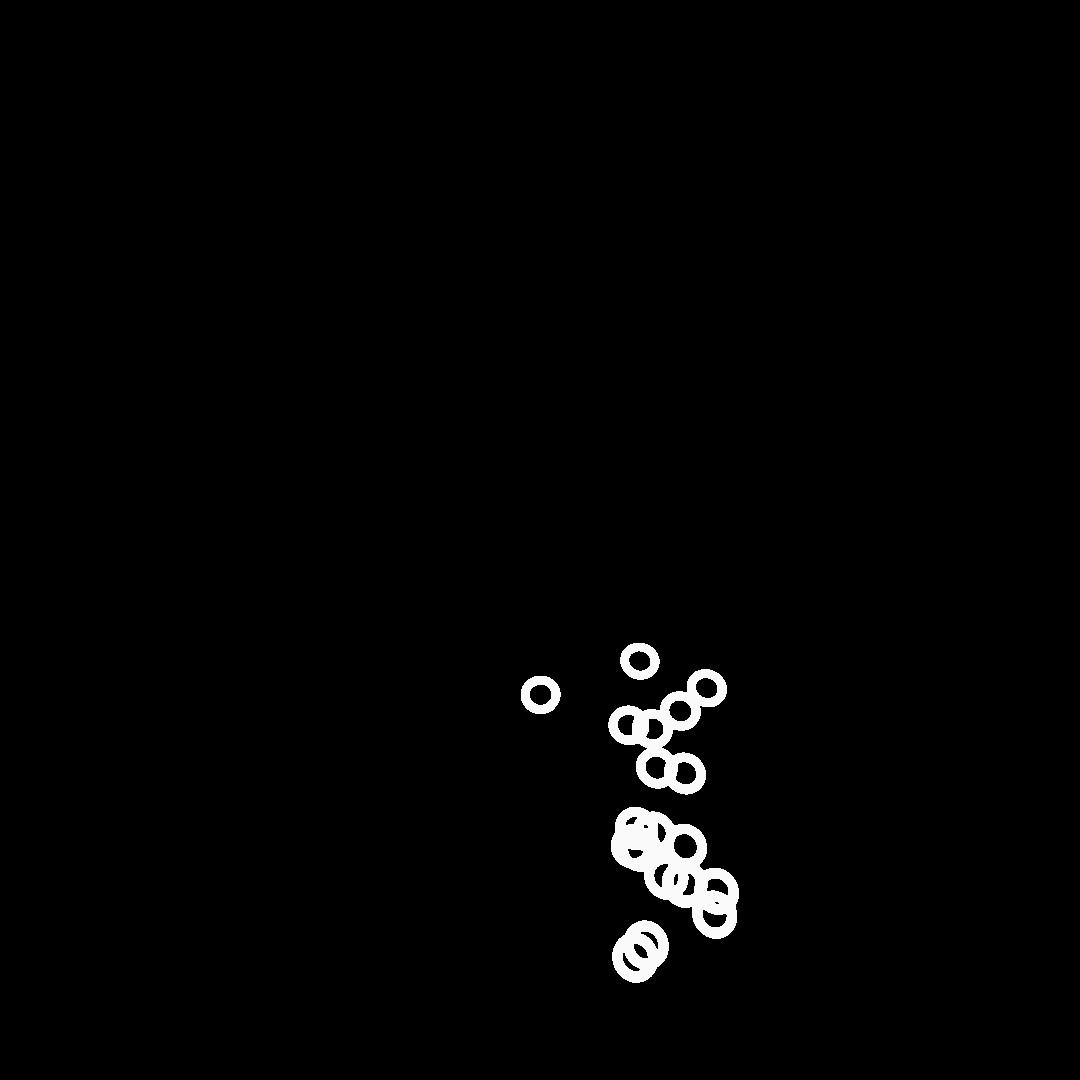

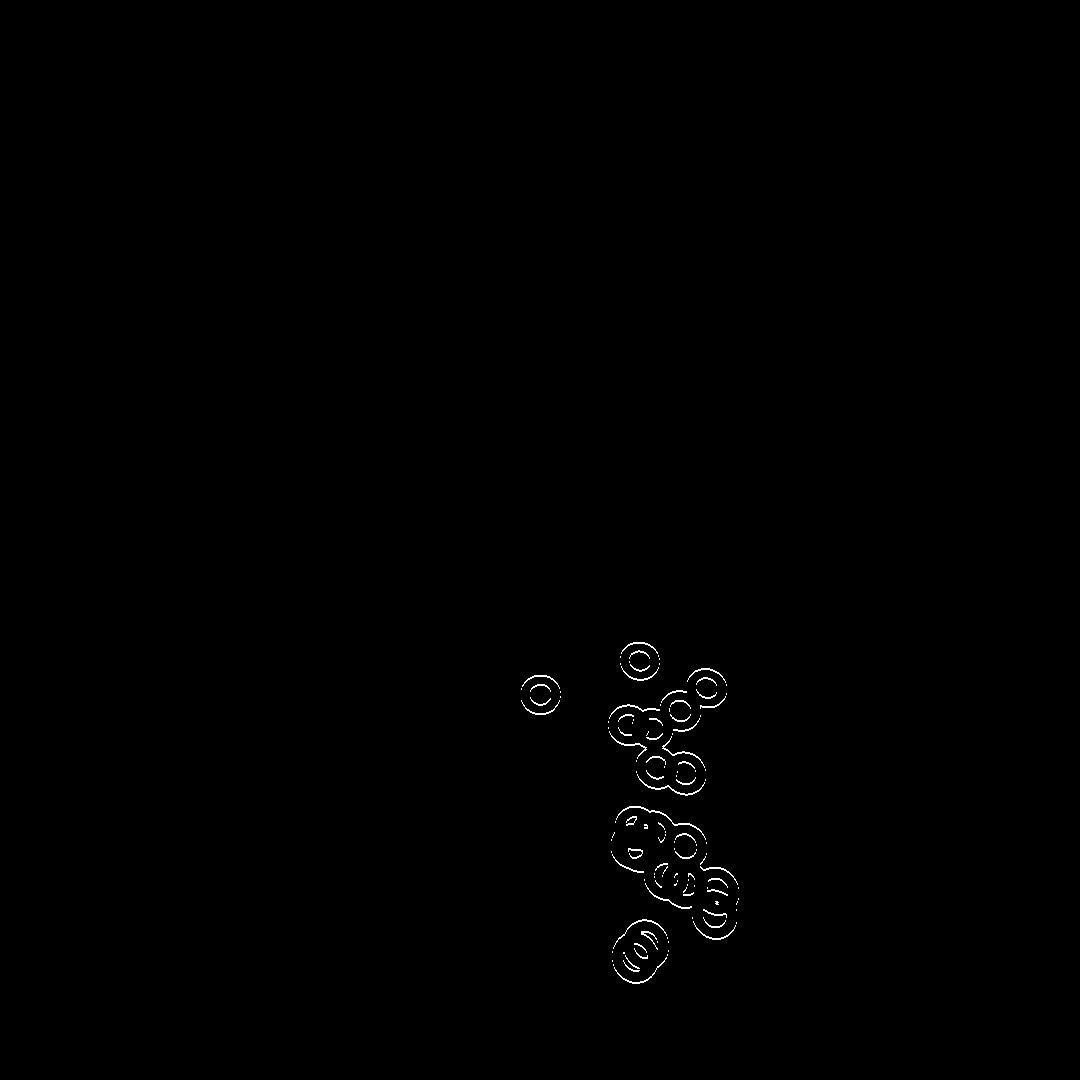

circles detected = 28
source print


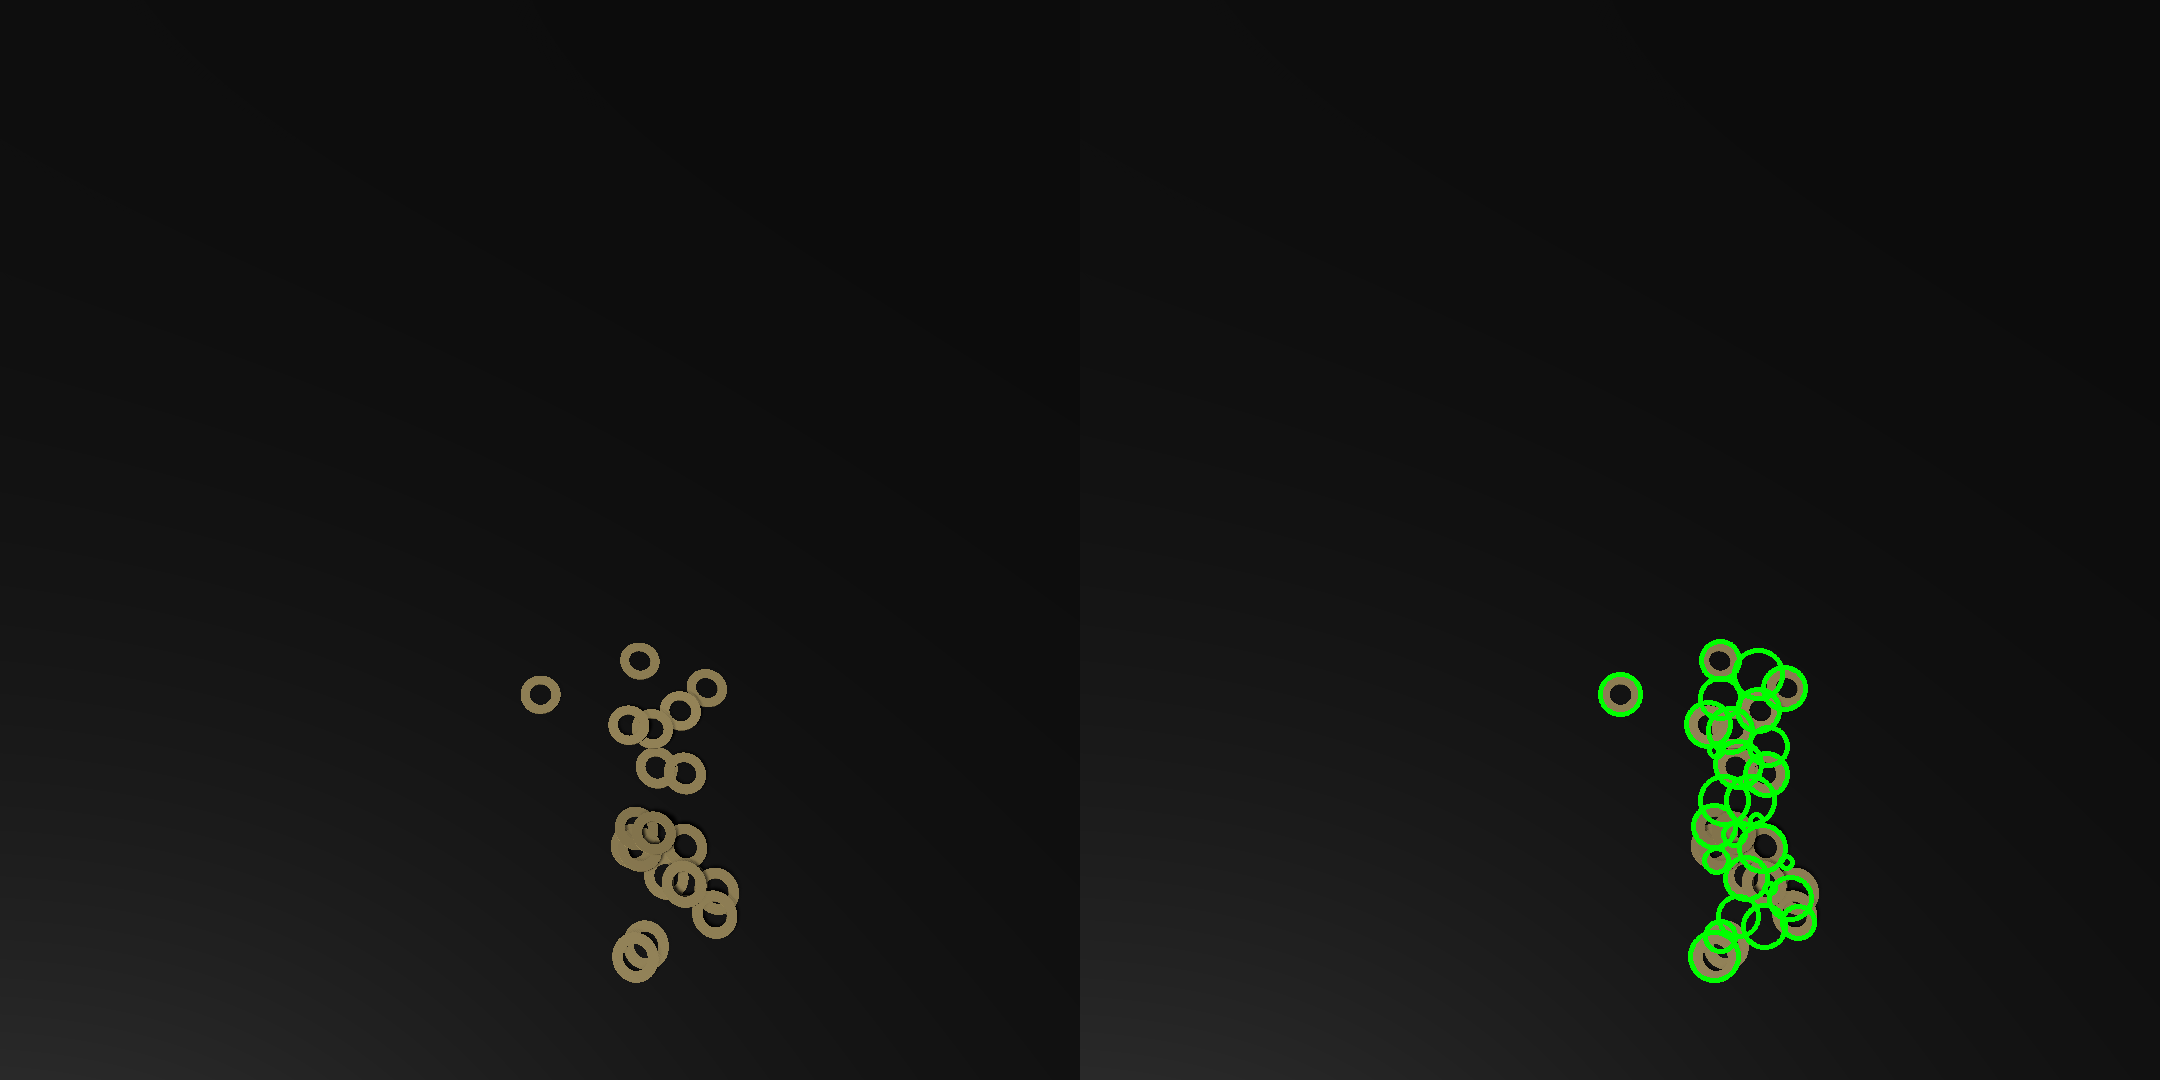

count = 28
ground truth = 20

 Root Mean Squared Error on Data: 8.0

 Mean Absolute Error on Data: 8.0


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred_counts = []
gt_counts = []

directory = '/content/drive/Shareddrives/CIS680 - Final Project Fall \'21/dataset-split/test'
i = 0
show =True
for filename in os.listdir(directory):
    if i<1:
      if filename.endswith(".png"):
        print("image name:%s"%(filename))
        img = cv2.imread(directory+'/'+filename,cv2.IMREAD_COLOR)
        count = get_count(img,show)
        print("count = %d"%(count))
        pred_counts.append(count)
        gtcount = get_label(file2id["img/%s"%(filename)])
        gt_counts.append(gtcount) 
        print("ground truth = %d"%(gtcount))
        i+=1
    

pred_counts = np.array(pred_counts)
gt_counts = np.array(gt_counts)

rmse = np.sqrt(mean_squared_error(pred_counts, gt_counts))
mae = mean_absolute_error(pred_counts, gt_counts)

print('\n Root Mean Squared Error on Data: {}'.format(rmse))
print('\n Mean Absolute Error on Data: {}'.format(mae))